#**Loan Repayment Challenge**




By: Suhasan Kanagasabapathy

Software used: Google Colab with the data uploaded to the drive. 

Background: This was one of the assessments I did for a Data Scientist position at a fintech company. It was a great fun working with real data. Being one of my first Data Science projects, I had learnt alot! Thought it would be great to share it on my GitHub. Enjoy!

Note: For privacy reasons, I would not be sharing details about the company and their data. I will refer them as Company X. Though, I suppose the data is simulated anyway.

In [ ]:
# importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# **1. Define the Problem**

Before we dive into the sea of data, it is crucial to understand the problem we are trying to solve. This helps give a certain structure or approach before starting to analyse the data given.

For this, I asked myself "What is the business objective here? What are we trying to achieve?". Company X is trying to assess the risk of the loan applicant. How can we use data to drive insights and potentially build a model which predicts if a certain loan applicant will pay off their loan in time?

But how do we know if an applicant is good in repaying their loans? Is there a number or score given? Let's keep this in mind when exploring the data given.

As mentioned in the introduction document, this will enable Company X to better price customers and mitigate losses in their portfolio. As someone who is just starting out in fintech/loan repayment field, one other objetive is also to understand the domain itself.

Now that it is clear, let's look at what data we have been provided. 

# **2. Gather and Understand the Data**

We are given 3 datasets. After looking through the data briefly on Excel and reading the dictionary document, the datasets can be summarised as:


1.   loan.csv: Details of loan applications (each specified by loanId)
2.   payment.csv: Details of transactions regarding a specific loanId
3.   clarity_underwriting_variables.csv: Variables returned by a data provider who underwrites loan. It gives a 'fraud score' for each loan application.

Note: I understand "underwriting" as assessing the risk or quality of a loan application. 



In [ ]:
# loading datasets

loan = pd.read_csv("file path.csv")
pay = pd.read_csv("file path.csv")
clarity = pd.read_csv("file path.csv")

In [ ]:
# checking the lengths

print('Length of loan data', len(loan))
print('Length of payment data', len(pay))
print('Length of clarity data', len(clarity))

Length of loan data 577682
Length of payment data 689364
Length of clarity data 49752


**Understanding the loan applications data**

Relating back to our objective, how can this data help us? This data is crucial since it has all the information we would get in an application and I assume this is one the earliest information Company X receives when assessing an application. Hence, we would want to know what to look for to better assess an applicant. 

In [ ]:
# understanding the loan.csv
loan.head(5)

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23T17:29:01.940000,False,NaN,0.0,False,0,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,NaN,5669ef78e4b0c9d3936440e6,1
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01T13:51:14.709000,False,NaN,0.0,False,0,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,NaN,579eab11e4b0d0502870ef2f,1
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06T23:58:08.880000,False,NaN,0.0,False,0,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,NaN,555b1e95e4b0f6f11b267c18,1
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05T22:31:34.304000,False,NaN,0.0,False,0,Rejected,350.0,814.37,NV,bvMandatory,3,NaN,5754a91be4b0c6a2bf424772,1


The column 'loanStatus' is interesting since it might inform us on the quality (Remember this was what we were wondering earlier). Let's look at the entries. 

It looks like most of the loan applications were either withdrawn or rejected. I don't think this is very useful since there is no real way of knowing if that applicat would have paid if funded in the first place. 

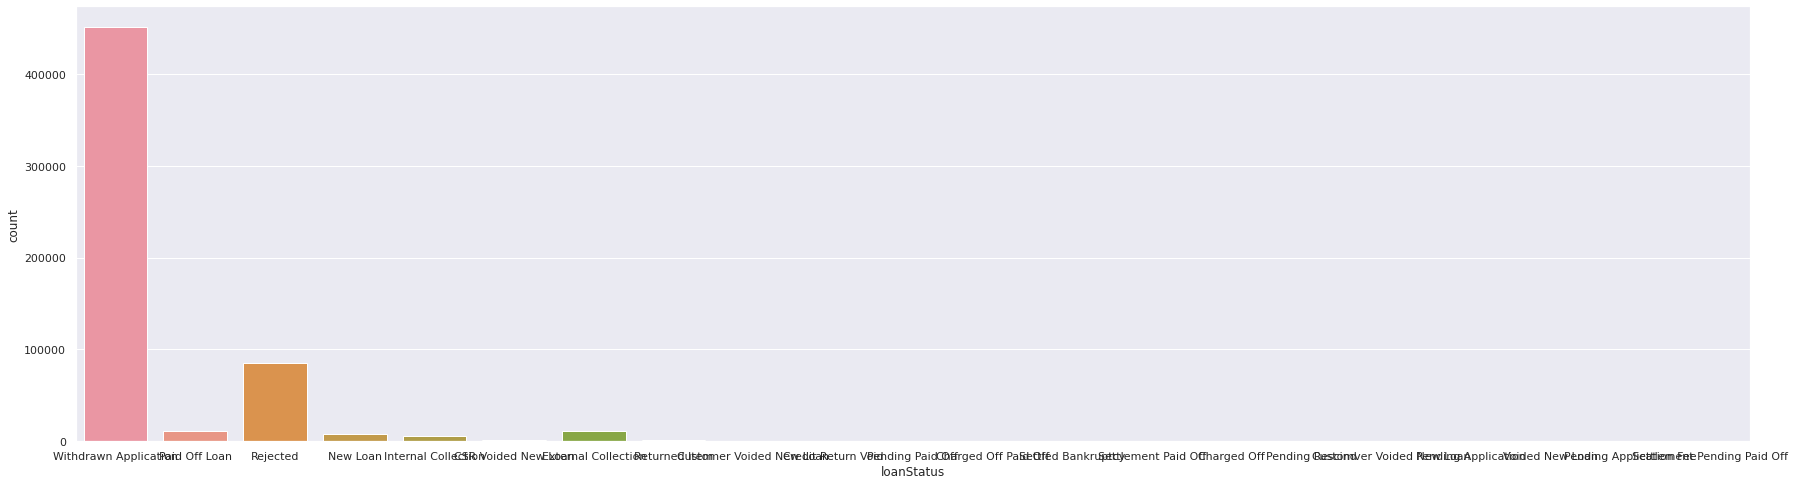

In [ ]:
# checking loan status
sns.set(rc={'figure.figsize':(30,8)})
sns.countplot(loan.loanStatus)

**Understanding the payments data**

Now, this payment data might give us the metric we are looking for, since this is essentially a historical record of all transactions regarding the loans. 

A little bit about the structure of the data: each row is an ACH attempt. Therefore, there are multiple rows related to individual loan applications, as we see below. 


In [ ]:
# understanding the payment.csv
pay.head(5)

,loanId,installmentIndex,isCollection,paymentDate,principal,fees,paymentAmount,paymentStatus,paymentReturnCode
0,LL-I-00000021,1,False,2014-12-19T05:00:00,22.33,147.28,169.61,Checked,NaN
1,LL-I-00000021,2,False,2015-01-02T05:00:00,26.44,143.17,169.61,Checked,NaN
2,LL-I-00000021,3,False,2015-01-16T05:00:00,31.30,138.31,169.61,Checked,NaN
3,LL-I-00000021,4,False,2015-01-30T05:00:00,37.07,132.54,169.61,Checked,NaN
4,LL-I-00000021,5,False,2015-02-13T05:00:00,43.89,125.72,169.61,Checked,NaN



I am particularly interested in the 'paymentStatus' column. This tells us if an applicant has paid succesfully. 

It looks like most of the status are either checked, rejected, cancelled or None. A little bit on what they mean:

1.   Checked – payment is successful
2.   Rejected – payment is unsuccessful
3.   Cancelled – payment is cancelled
4.   Pending – ACH attempt has been submitted to clearing house but no response yet
5.   Skipped – payment has been skipped
6.   None – No ACH attempt has been made yet – usually because the payment is
scheduled for the future
7.   Rejected awaiting retry – retrying a failed ACH attempt.

Therefore, I think this can be a good metric to assess the loan repayment quality. 

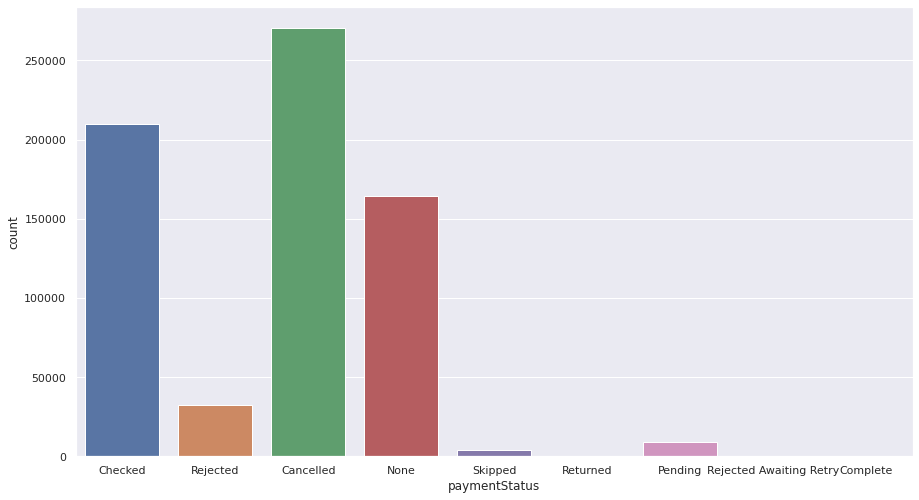

In [ ]:
# paymentStatus column
sns.set(rc={'figure.figsize':(15,8.27)})
sns.countplot(pay.paymentStatus)

Besides, I am interested to see if the 'paymentReturnCode' might be relevant since it might show why and how often transactions are unsuccesful. 

It turns out the most common cause of rejection is insufficient funds. This reduces the chances of a default payments due to external circumstances. i.e. we will know that it is the applicant's fault!

I do not think the other columns are very useful to the business objective.

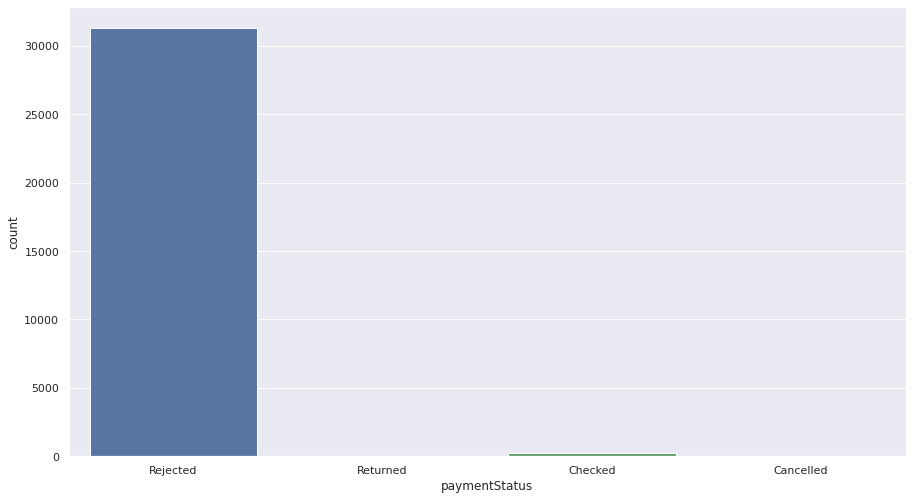

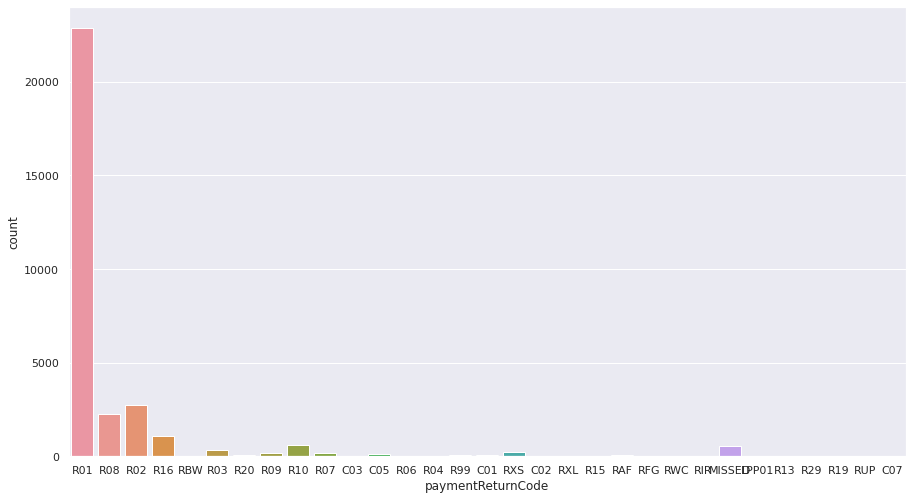

In [ ]:
# investigating the error codes with the paymentStatus

pay_error = pay.copy()
pay_error = pay_error.dropna(subset = ['paymentReturnCode'])  # dropping Nan in code column
sns.countplot(pay_error['paymentStatus'])
plt.show()
# assume the error code is only returned when the payment is rejected

sns.set(rc={'figure.figsize':(15,8.27)})
sns.countplot(pay_error['paymentReturnCode'])
# most common reason is R01(insufficient fund)  -  no

**Understanding the clarity_underwriting_variables data**

This data has a lot of columns/variables. The most interesting one is certainly 'clearfraudscore' column. It looks like the data provider is running the assessment based on the previous columns/variables and returning a fraud score for each loan application. 

Higher score suggests lower default probability. Ha! Now, we can see if this is related to the payment metric we were interested in above. (A way to test these clarity service providers!)



In [ ]:
# understanding the clarity_underwriting_variables.csv
clarity.head(5)

,.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago,.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago,.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago,.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago,.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict,.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators,.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithaddress,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryageyoungerthanssnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.ssnreportedmorefrequentlyforanother,.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbytradeopenlt90days,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssninvalid,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.morethan3inquiriesinthelast30days,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedpriortossnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseformatinvalid,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnrecordedasdeceased,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.inquirycurrentaddressnotonfile,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.highprobabilityssnbelongstoanother,.underwritingdataclarity.clearfraud.clearfraudindicator.maxnumberofssnswithanybankaccount,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnrecordedasdeceased,.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbynewtradeonly,.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedbeforeage18,.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithstate,.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseinconsistentwithonfile,.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedascellphone,.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedashomephone,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamematch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncodedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncodedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype,.underwritingdataclarity.clearfraud.clearfraudiden

Now that we have looked at all 3 datsets, let's see how they relate to each other. 



*   loan.csv and payment.csv can be joined by 'LoanId'
*   loan.csv and clarity_underwriting_variables.csv can be joined by 'clarityFraudId' or 'underwritingid'.

Therefore, we could merge all 3 into 1 master data. The loan.csv will be the foundation. It would have about 32000 rows with entries from all 3 datasets. 

I think it is pretty useful amount of data to work with!



In [ ]:
# understanding the relevance between datasets

pay_loan_merge = pay.merge(loan, how = 'inner', left_on='loanId', right_on='loanId')
loan_clarity_merge = loan.merge(clarity, how = 'inner', left_on='clarityFraudId', right_on='underwritingid')
print('Length of pay-join-loan data', len(pay_loan_merge['loanId'].unique()))
print('Length of loan-join-clarity data', len(loan_clarity_merge['loanId'].unique()))
all_merge = pay.merge(loan_clarity_merge, how = 'inner', left_on='loanId', right_on='loanId')
print('Length of all merged data', len(all_merge['loanId'].unique()))

Length of pay-join-loan data 39952
Length of loan-join-clarity data 36328
Length of all merged data 32312


#**3. Clean and Prepare the Data**

Our first objective is to define a metric on the loan repayment quality. Earlier we have decided to use the payment.csv. 

In payment.csv, there are multiple transactions related to individual loan applications. Mostly are series of installments. So, let's define a metric called 'Score' as the fraction of transactions that return succesful.

Therefore, the formula is:
Score = # of 'Checked' for each 'laonId' / # of total ACH attempts for each 'loanId'. 
The range will be from 0 to 1. 

We will remove 'None' because we want to separate the unsettled payments from future payments. We will assume labels beside 'Checked' and 'None' indicate a failed payment. We saw earlier this is mainly comprised of 'Rejected' and 'Cancelled'. 

Note: I am assuming 'Cancelled' refers to a failed payment. I would have liked to know more about the mechanism behind it and what causes it. Nonetheless, I am including because in this case, Company X is not receiving a payment. 

Length before dropping None 689364
False


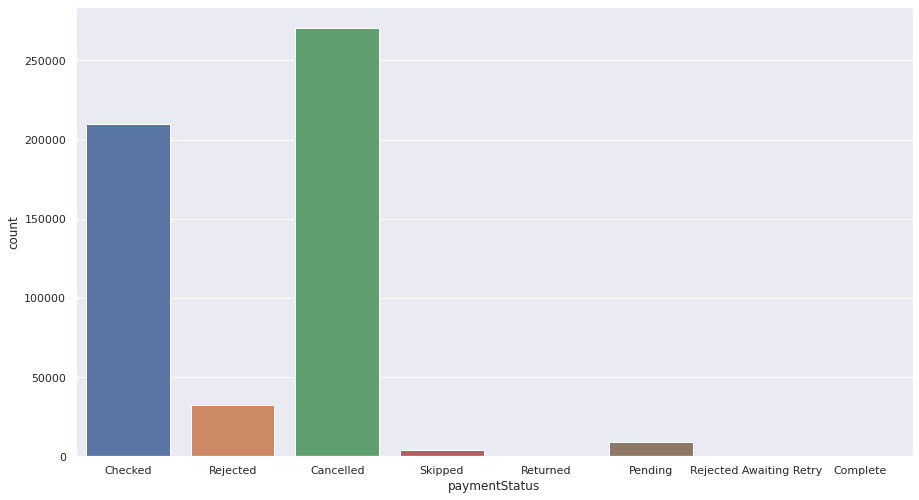

In [ ]:
# removing rows with 'None' from paymentStatus
print('Length before dropping None', len(pay['paymentStatus']))
pay['paymentStatus'] = pay['paymentStatus'].replace(to_replace='None', value=np.nan)
pay['paymentStatus'].dropna()

# check if all None has been removed  -> yes
print('None' in list(pay['paymentStatus']))
sns.countplot(pay.paymentStatus)

In [ ]:
# defining the metric function
def score(series):
  check_num = series.count('Checked')
  score = check_num/len(series)
  return round(score, 4)

score(list(pay[pay['loanId'] == 'LL-I-00000021']['paymentStatus']))  # testing for a specific loanId  -> works

0.9231

Since most of the loan data is comprised of withdrawn applications and thus do not appear in payment.csv, only 6.9% of loan.csv is being used.

In [ ]:
# since we are following the payment data, I want to see how much of the loan data is in payment data
id_pay = len(list(pay['loanId'].unique()))
id_loan = len(list(loan['loanId'].unique()))

print(id_pay, ' ids in payment data')
print(id_loan, ' ids in loan data')

pay_loan = pay.merge(loan, how = 'inner', left_on='loanId', right_on='loanId')
print(len(pay_loan['loanId'].unique()), ' ids are in both data')

print(round(id_pay/id_loan*100,2), '% of total loan ids are in the payment data')

39952  ids in payment data
577427  ids in loan data
39952  ids are in both data
6.92 % of total loan ids are in the payment data


Now, let's try to implement the metric function on the payment dataset. I was looking for a custom aggreate function method, using pandas, on the payment dataset, grouped by loanId. I spent way more time than I anticipated in this and to save time, I decided to go with a more manual way. 

It might be a bit slower but it should work. It is a good way to show my Python skills to Company X :)

Note: Initially I thought the method was on a loop or something (because it took long!). So, to solve this, I did for the first 100 values. And slowly to more entries to understand how long it would take. Finally got to work with all ~40,000 data. To save running time in the future, I saved the results in a csv and loaded it later in the notebook.

Given time and guidance, I think I could find a faster way.

In [ ]:
# calculating the metric the manual way 
# attempt: try splitting a portion of it and do the analysis  -> first x loan ids
# another way is using aggregating function -> cant seem to find a way, so using the manual way for now

loan_list = list(pay['loanId'].unique())
score_dict = {}
for loanid in loan_list:
  status = list(pay[pay['loanId'] == loanid]['paymentStatus'])
  score_dict[loanid] = score(status)

score_df = pd.DataFrame.from_dict(score_dict, orient='index', columns=['Score'])
score_df.reset_index(level=0, inplace=True)
score_df.columns = ['loanId', 'Score']

score_df.to_csv("file path.csv", index = False)

Let's take a slight detour to the loan and the clarity_underwriting data. I shall get the fraudscore from the clarity and merge with the loan data. My plan is to use this merged data with the score data above. So, we can do all the analysis on this master data. 

Note: I am assuming that we do not need the 50+ variables in clarity_underwriting.csv besides the fraudscore. My rationale is that the score represents the other variables. More information on this underwriting process would be helpful. This also reduces the dimensionality of the data, hence reducing running time. 

In [ ]:
# merging the clarity and loan data
loan_clarity = loan.merge(clarity, how = 'left', left_on='clarityFraudId', right_on='underwritingid')  # left join to include all entries in loan data
loan_clarity_2 = loan.merge(clarity, how = 'inner', left_on='clarityFraudId', right_on='underwritingid')
print(len(loan_clarity_2),'(',round(len(loan_clarity_2)/len(loan)*100,2) , '%)' ' from loan datasets have underwriting')

# only keeping "clearfraudscore" feature from clarity 
loan_clarity = loan_clarity[['loanId', 'anon_ssn', 'payFrequency', 'apr', 'applicationDate',
       'originated', 'originatedDate', 'nPaidOff', 'approved', 'isFunded',
       'loanStatus', 'loanAmount', 'originallyScheduledPaymentAmount', 'state',
       'leadType', 'leadCost', 'fpStatus', 'clarityFraudId', 'hasCF', 'clearfraudscore']]
loan_clarity.head(5)

36334 ( 6.29 %) from loan datasets have underwriting


,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,clearfraudscore
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23T17:29:01.940000,False,NaN,0.0,False,0,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,NaN,5669ef78e4b0c9d3936440e6,1,NaN
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,879.0
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01T13:51:14.709000,False,NaN,0.0,False,0,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,NaN,579eab11e4b0d0502870ef2f,1,NaN
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06T23:58:08.880000,False,NaN,0.0,False,0,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,NaN,555b1e95e4b0f6f11b267c18,1,NaN
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05T22:31:34.304000,False,NaN,0.0,False,0,Rejected,350.0,814.37,NV,bvMandatory,3,NaN,5754a91be4b0c6a2bf424772,1,NaN


In [ ]:
# join the payment score with the loan_clarity data for analysis

score_load =  pd.read_csv("file path.csv")
score_load = score_load.rename(columns = {'Score': 'paymentScore'})
pay_loan = score_load.merge(loan_clarity, how = 'inner', left_on='loanId', right_on='loanId')
pay_loan.head(5)

,loanId,paymentScore,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,clearfraudscore
0,LL-I-00000021,0.9231,3e02899b53aa4877f9823b8ed5d5a6f1,B,478.67,2014-12-03T00:31:22.306000,True,2014-12-03T03:12:58.466000,NaN,True,1,Settlement Paid Off,800.0,2035.32,OH,lead,25,Checked,NaN,0,NaN
1,LL-I-00000231,0.1000,8775996c9eb007d33a874648e3857e82,B,478.67,2014-12-03T00:39:02.866000,True,2014-12-02T17:47:22,NaN,True,1,External Collection,800.0,1919.28,OH,lead,6,Checked,NaN,0,NaN
2,LL-I-00000238,0.4375,9e70eecb9c114068d5ef4431a40f7d66,B,478.67,2014-12-03T00:39:07.767000,True,2014-12-04T17:26:49.668000,NaN,True,1,External Collection,800.0,1919.28,OH,lead,25,Checked,NaN,0,NaN
3,LL-I-00000308,0.0455,6860de82ee70ce65b8df8f3cee51dff5,S,705.59,2014-12-03T00:41:27.773000,True,2014-12-03T03:12:56.416000,NaN,True,1,External Collection,200.0,739.08,OH,lead,25,Checked,NaN,0,NaN
4,LL-I-00000355,0.0000,37b6d5d2c65aa5693d52405046102679,B,478.67,2014-12-03T00:43:10.714000,True,2014-12-03T03:12:55.376000,NaN,True,1,External Collection,500.0,1199.55,OH,lead,25,Rejected,NaN,0,NaN


Here is the master data! Let's have a closer look and clean it up a little.

In [ ]:
# remove unncessary columns
col_remove = ['loanId', 'anon_ssn', 'clarityFraudId']
pay_loan = pay_loan.drop(columns = col_remove)
pay_loan.head(2)

,paymentScore,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,hasCF,clearfraudscore
0,0.9231,B,478.67,2014-12-03T00:31:22.306000,True,2014-12-03T03:12:58.466000,NaN,True,1,Settlement Paid Off,800.0,2035.32,OH,lead,25,Checked,0,NaN
1,0.1000,B,478.67,2014-12-03T00:39:02.866000,True,2014-12-02T17:47:22,NaN,True,1,External Collection,800.0,1919.28,OH,lead,6,Checked,0,NaN


In [ ]:
#  summary
print(pay_loan.info())

# check the missing values
pay_loan.isnull().sum(axis=0)/len(pay)*100

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39952 entries, 0 to 39951
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   paymentScore                      39952 non-null  float64
 1   payFrequency                      39952 non-null  object 
 2   apr                               39952 non-null  float64
 3   applicationDate                   39952 non-null  object 
 4   originated                        39952 non-null  bool   
 5   originatedDate                    39930 non-null  object 
 6   nPaidOff                          39931 non-null  float64
 7   approved                          39952 non-null  bool   
 8   isFunded                          39952 non-null  int64  
 9   loanStatus                        39952 non-null  object 
 10  loanAmount                        39952 non-null  float64
 11  originallyScheduledPaymentAmount  39952 non-null  float64
 12  stat

paymentScore                        0.000000
payFrequency                        0.000000
apr                                 0.000000
applicationDate                     0.000000
originated                          0.000000
originatedDate                      0.003191
nPaidOff                            0.003046
approved                            0.000000
isFunded                            0.000000
loanStatus                          0.000000
loanAmount                          0.000000
originallyScheduledPaymentAmount    0.000000
state                               0.000000
leadType                            0.000000
leadCost                            0.000000
fpStatus                            0.156956
hasCF                               0.000000
clearfraudscore                     1.121759
dtype: float64

Most columns are complete. Missing values in originatedDate, nPaidOff, fpStatus, clearfraudscore. 
Since the fraction is less than about 1%, I will drop the missing rows.

In [ ]:
# clean missing values
pay_loan = pay_loan.dropna()
print(pay_loan.isnull().sum(axis=0)/len(pay)*100)
print(len(pay_loan))

paymentScore                        0.0
payFrequency                        0.0
apr                                 0.0
applicationDate                     0.0
originated                          0.0
originatedDate                      0.0
nPaidOff                            0.0
approved                            0.0
isFunded                            0.0
loanStatus                          0.0
loanAmount                          0.0
originallyScheduledPaymentAmount    0.0
state                               0.0
leadType                            0.0
leadCost                            0.0
fpStatus                            0.0
hasCF                               0.0
clearfraudscore                     0.0
dtype: float64
32077


In [ ]:
pay_loan.head(2)

,paymentScore,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,hasCF,clearfraudscore
292,0.1600,W,478.67,2015-01-31T00:10:21.133000,True,2015-02-02T18:52:53.444000,0.0,True,1,Paid Off Loan,600.0,1463.49,OH,lead,6,Checked,1,768.0
293,0.0476,B,570.32,2015-01-31T02:07:32.590000,True,2015-02-02T19:58:48.514000,0.0,True,1,External Collection,400.0,1087.90,OH,lead,10,Checked,1,564.0


In [ ]:
pay_loan.describe()

,paymentScore,apr,nPaidOff,isFunded,loanAmount,originallyScheduledPaymentAmount,leadCost,hasCF,clearfraudscore
count,32077.000000,32077.000000,32077.000000,32077.0,32077.000000,32077.000000,32077.000000,32077.0,32077.000000
mean,0.311910,532.563734,0.169748,1.0,656.536334,1805.567175,13.795960,1.0,685.397481
std,0.317781,128.601776,0.597954,0.0,496.412874,1313.613335,21.408671,0.0,127.250395
min,0.000000,29.990000,0.000000,1.0,100.000000,188.410000,0.000000,1.0,122.000000
25%,0.071400,449.000000,0.000000,1.0,400.000000,1074.020000,3.000000,1.0,594.000000
50%,0.214300,590.000000,0.000000,1.0,500.000000,1406.330000,6.000000,1.0,693.000000
75%,0.461500,645.000000,0.000000,1.0,700.000000,2025.980000,25.000000,1.0,784.000000
max,1.000000,681.000000,20.000000,1.0,4687.000000,16868.150000,200.000000,1.0,965.000000


#**4. Analyze the Data**

So, we have a clean data ready to analyse! At the end of this section, we will also prepare it for modelling. 

For now, let's do some preliminary analysis on some features. 

Categorical features: payFrequency, originated, approved, loanStatus, state, leadType, fpStatus, hasCF, isFunded

Numerical features: paymentScore, apr, nPaidOff, loanAmount, orginallyscheduledAmount, leadCost, fraudscore

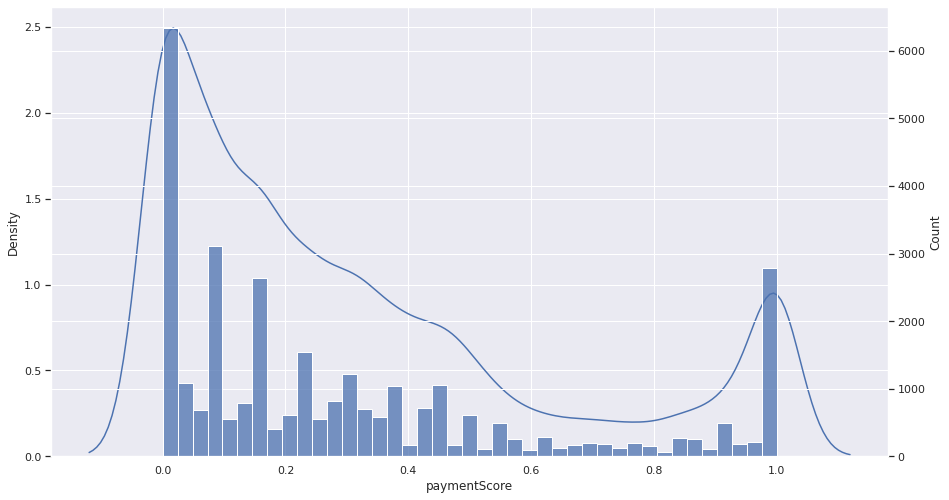

In [ ]:
# lets look at the distribution of score
fig, ax1 = plt.subplots()
sns.kdeplot(pay_loan['paymentScore'], ax=ax1)
ax2 = ax1.twinx()
sns.histplot(pay_loan['paymentScore'], ax=ax2)
plt.show()
# the range [0,0.5] is denser than [0.5,1]
# we might be able to reduce this to a binary class of (0,1) --> later, for now we will keep it continuous

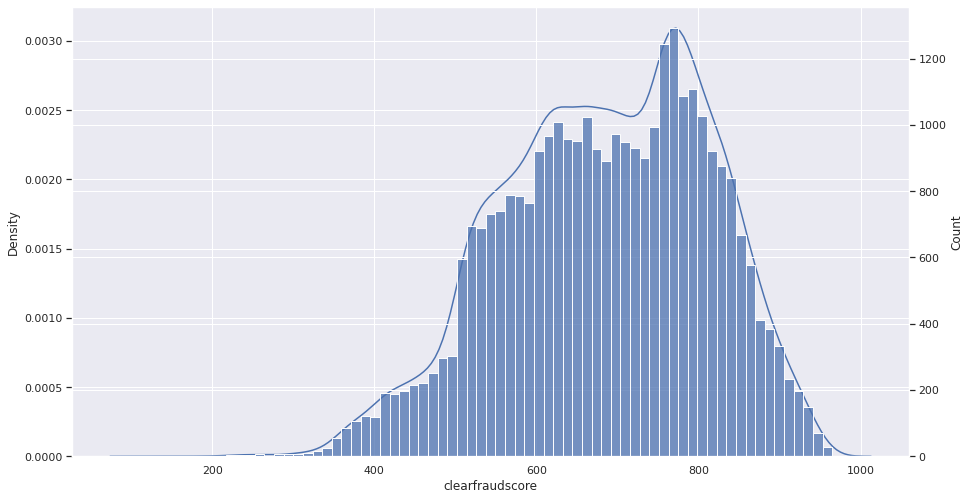

In [ ]:
# lets look at the distribution of score
fig, ax1 = plt.subplots()
sns.kdeplot(pay_loan['clearfraudscore'], ax=ax1)
ax2 = ax1.twinx()
sns.histplot(pay_loan['clearfraudscore'], ax=ax2)
plt.show()

# the fraudscore has smooth distribution  - will keep it continuous

Since 'paymentScore' is the target variable that we are looking to predict, let's see how other features correlate with it. 


In [ ]:
# defining plot functions to reuse
def scatter(var):                                                  # scatter plot for numerical features
  data = pd.concat([pay_loan['paymentScore'], pay_loan[var]], axis=1)
  sns.lmplot(x= var,y='paymentScore',data=data,fit_reg=True) 

def box(var, a = 20, b = 6):                                       # boxplot for categorical features
  data = pd.concat([pay_loan['paymentScore'], pay_loan[var]], axis=1)
  sns.set(rc={'figure.figsize':(a,b)})
  sns.boxplot(x=var, y="paymentScore", data=data)
  plt.show()

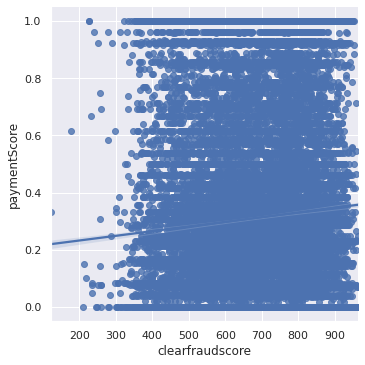

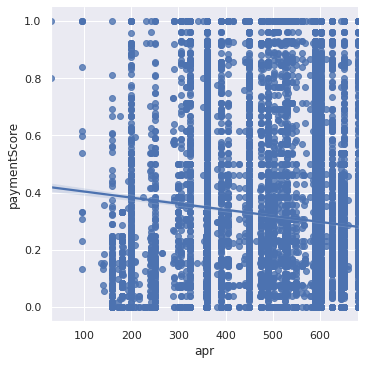

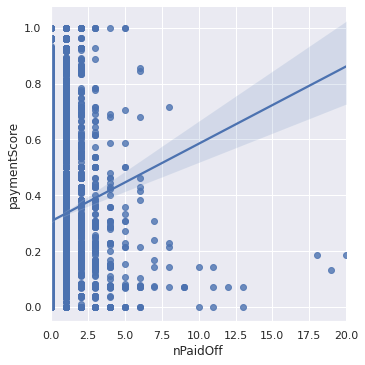

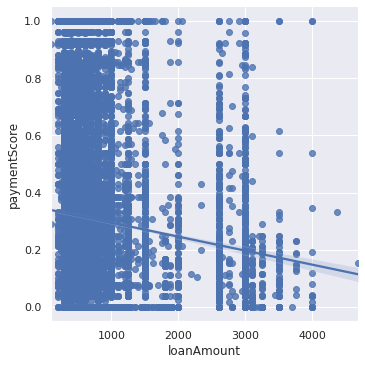

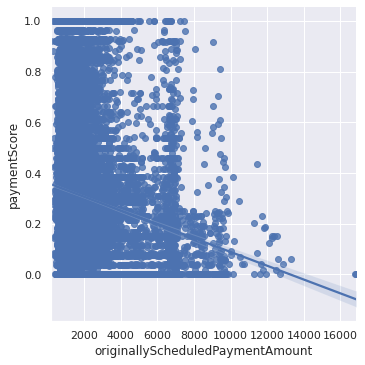

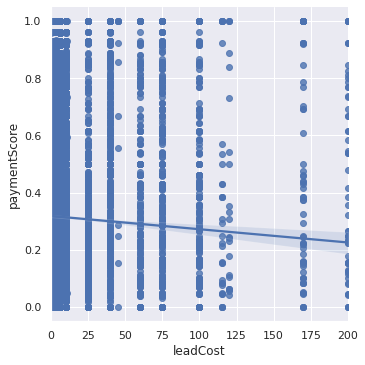

In [ ]:
# numerical features
scatter('clearfraudscore')   # has mild positive correlation
scatter('apr')               # has small neg correlation
scatter('nPaidOff')          # has positive correlation
scatter('loanAmount')        # has neg correlation
scatter('originallyScheduledPaymentAmount')   # has neg correlation
scatter('leadCost')          # has small correlation

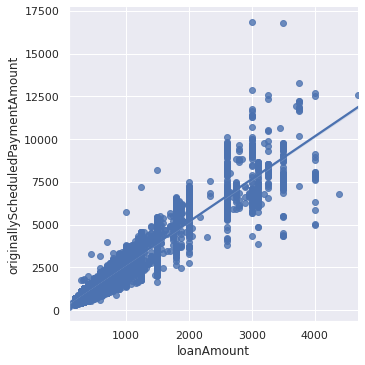

In [ ]:
# loanamount vs originallyScheduledPaymentAmount

data = pd.concat([pay_loan['originallyScheduledPaymentAmount'], pay_loan['loanAmount']], axis=1)
sns.lmplot(x='loanAmount',y='originallyScheduledPaymentAmount',data=data,fit_reg=True) 

# since they are highly correlated, we can remove one and keep the other. let's keep 'loanAmount'

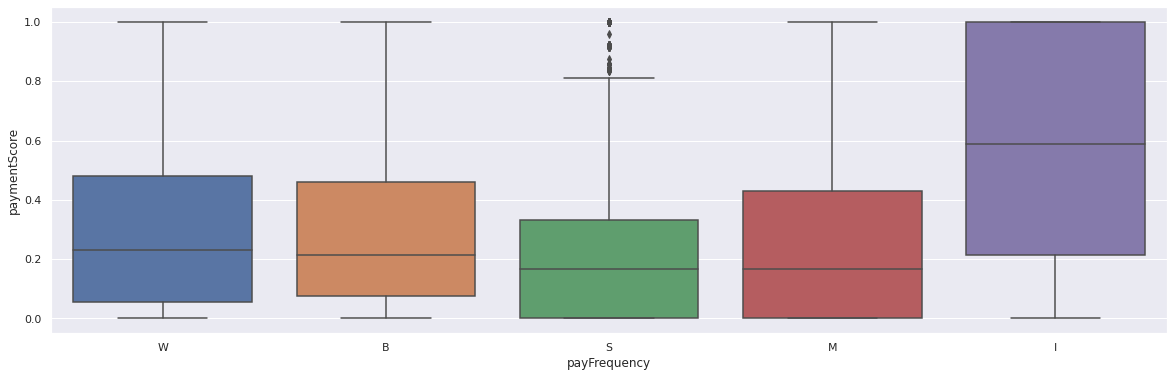

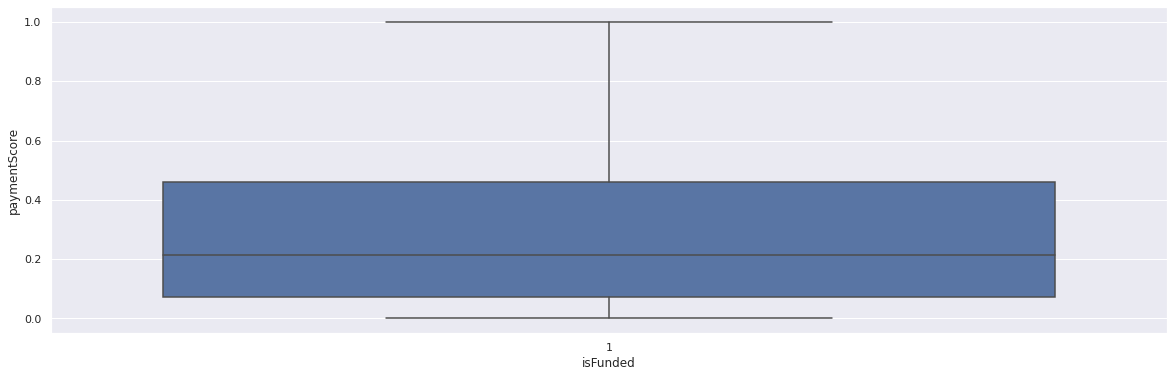

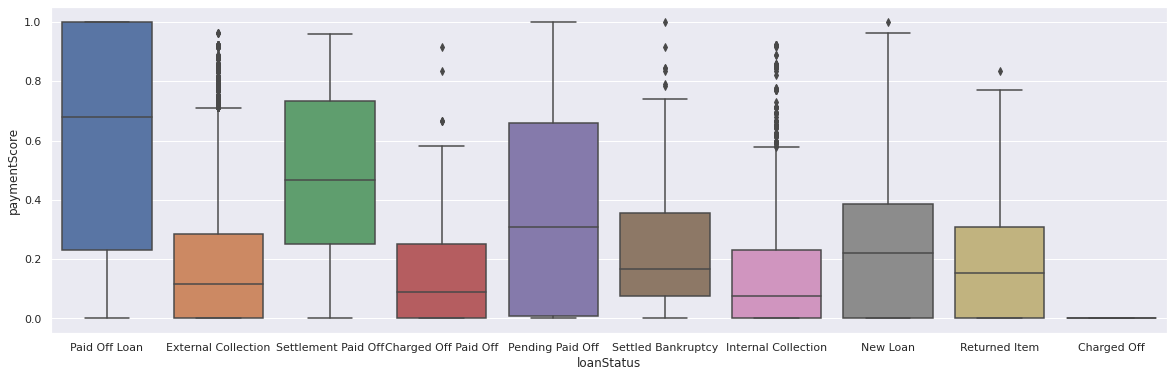

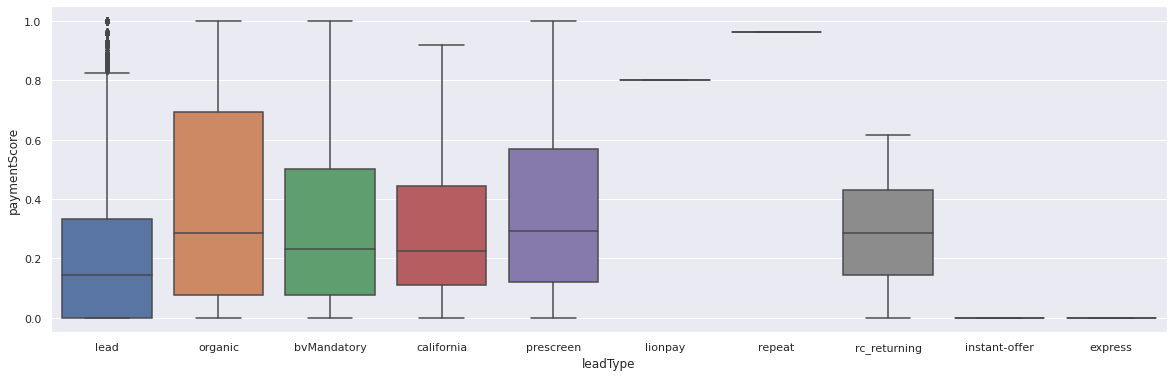

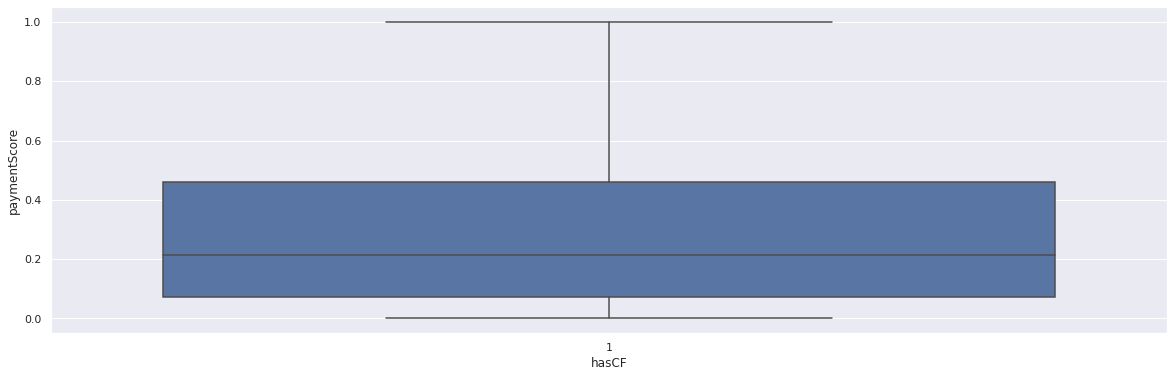

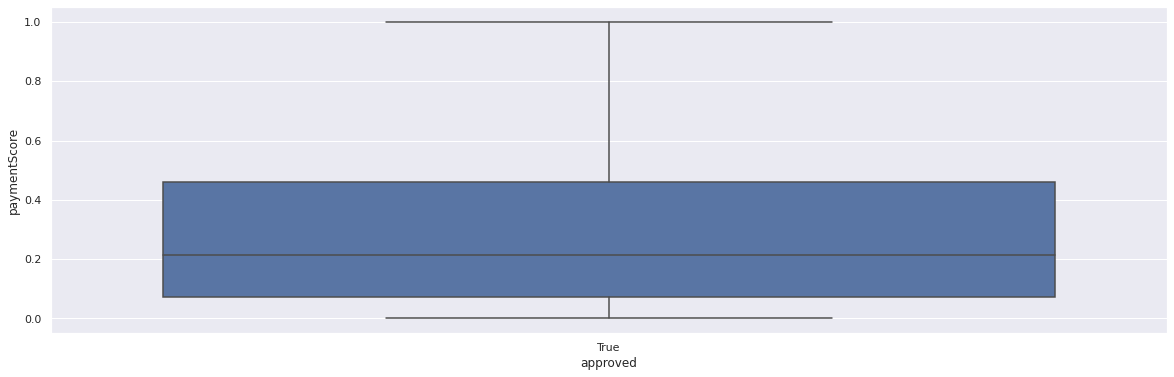

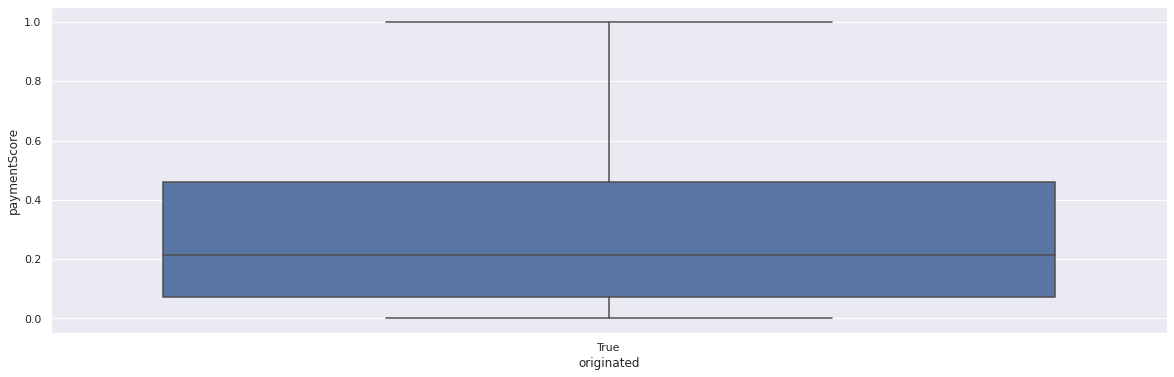

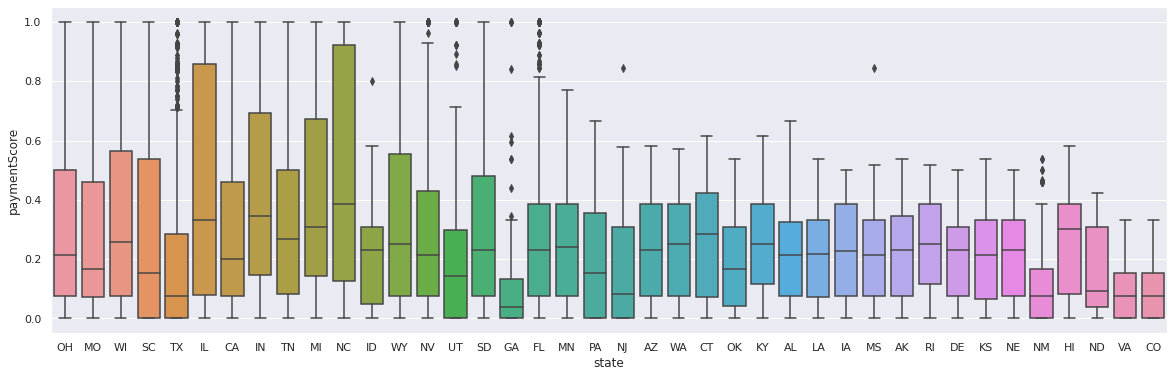

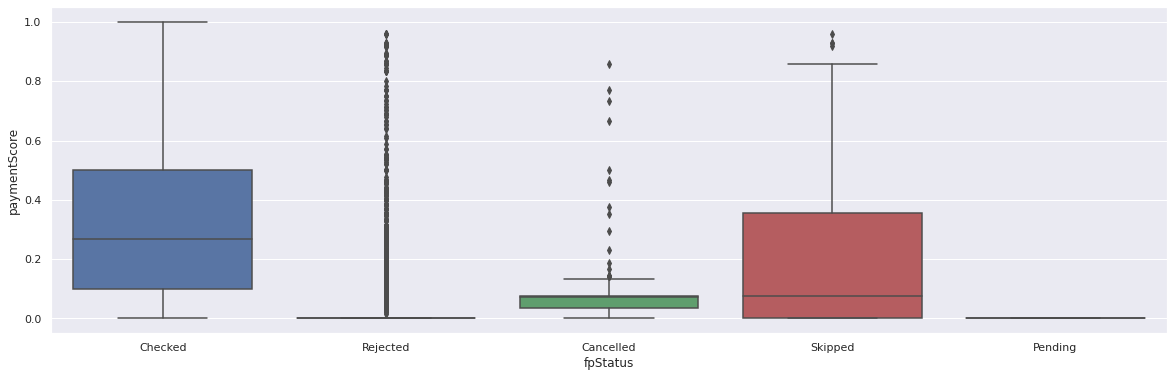

In [ ]:
# categorical features
box('payFrequency') # payFreq of I has higher score
box('isFunded')     # only 1 value is found (as expected) -> better remove this
box('loanStatus')   # various behaviours
box('leadType')     # various behaviours
box('hasCF')        # only 1 value is found -> better remove this
box('approved')     # only 1 value is found (as expected) -> better remove this
box('originated')   # only 1 value is found (as expected) -> better remove this
box('state', a = 20, b = 6)   # interesting correlation - IL, NC have good scores
box('fpStatus') 

I noticed that there is applicationDate and originationDate. Let's see how they correlate with paymentScore. 

For both, strangely, the score drops after 2016-10. I am not sure why so. Since there is a non-random behaviour, I will keep it. 

Note: This might not be a good feature to have in the model since it is possible the score changes in the future. Further investigation would be good. 

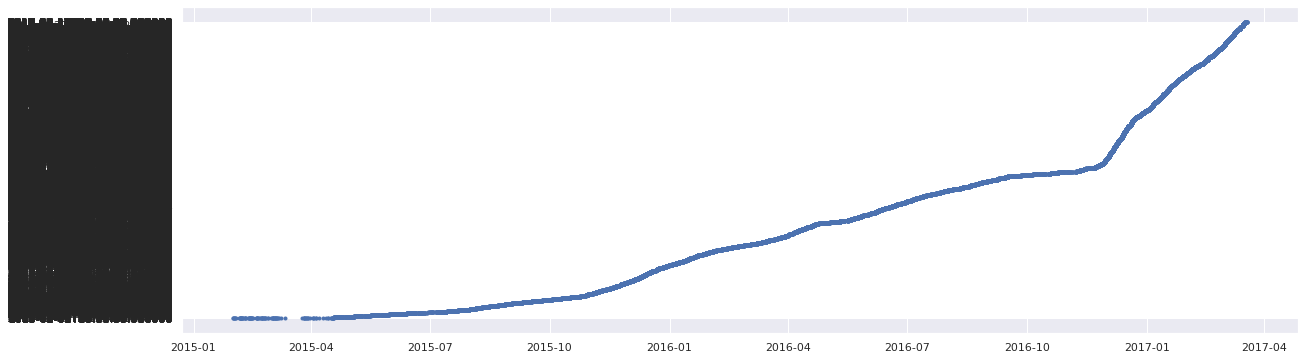

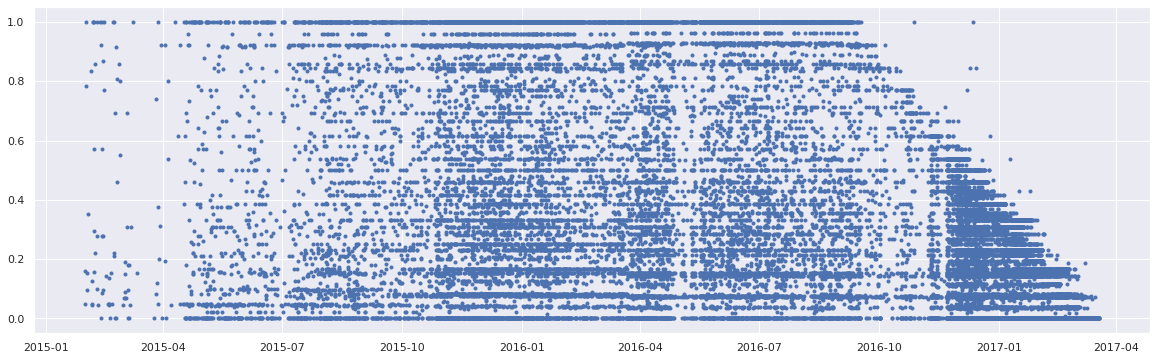

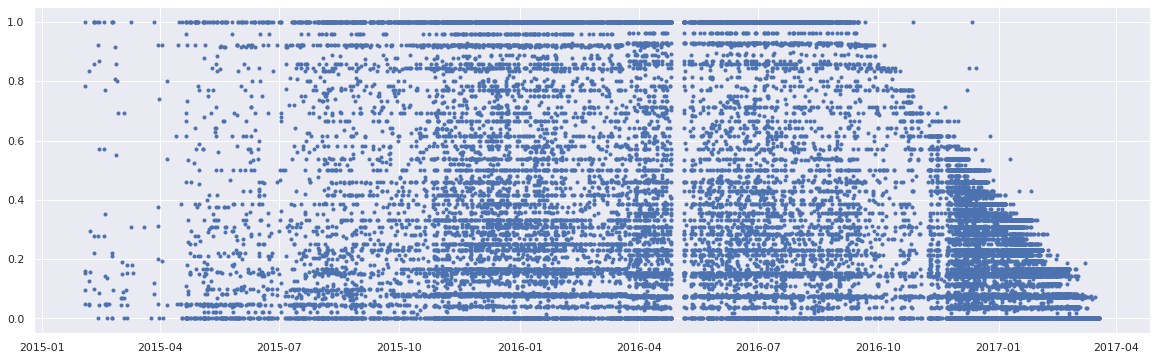

In [ ]:
# datetime data
pay_loan['applicationDate'] = pd.to_datetime(pay_loan['applicationDate'])
pay_loan['applicationDate'] = pd.to_datetime(pay_loan['applicationDate'])

plt.plot(pay_loan['applicationDate'], pay_loan['originatedDate'], '.')    # highly correlated - good to drop one: keep applicationDate
plt.show()

plt.plot(pay_loan['applicationDate'], pay_loan['paymentScore'], '.')      
plt.show()

pay_loan['originatedDate'] = pd.to_datetime(pay_loan['originatedDate'])
plt.plot(pay_loan['originatedDate'], pay_loan['paymentScore'], '.')

In [ ]:
# remove the cols with only one type of entry
col_remove = ['isFunded', 'hasCF', 'approved', 'originated', 'originallyScheduledPaymentAmount', 'originatedDate']
pay_loan = pay_loan.drop(columns = col_remove)
pay_loan.head(2)

,paymentScore,payFrequency,apr,applicationDate,nPaidOff,loanStatus,loanAmount,state,leadType,leadCost,fpStatus,clearfraudscore
292,0.1600,W,478.67,2015-01-31 00:10:21.133,0.0,Paid Off Loan,600.0,OH,lead,6,Checked,768.0
293,0.0476,B,570.32,2015-01-31 02:07:32.590,0.0,External Collection,400.0,OH,lead,10,Checked,564.0


I think I am happy with the columns above. Let's transform them so they are good for modelling. 

In [ ]:
# datetime
print('The earliest date is', min(pay_loan['applicationDate']))
diff = pay_loan['applicationDate'] - min(pay_loan['applicationDate'])
pay_loan['daysSincefirstDay'] = diff.dt.days
pay_loan = pay_loan.drop(columns = 'applicationDate')
pay_loan.head(5)

The earliest date is 2015-01-31 00:10:21.133000


,paymentScore,payFrequency,apr,nPaidOff,loanStatus,loanAmount,state,leadType,leadCost,fpStatus,clearfraudscore,daysSincefirstDay
292,0.1600,W,478.67,0.0,Paid Off Loan,600.0,OH,lead,6,Checked,768.0,0
293,0.0476,B,570.32,0.0,External Collection,400.0,OH,lead,10,Checked,564.0,0
296,1.0000,W,478.67,0.0,Paid Off Loan,800.0,OH,lead,10,Checked,691.0,0
298,0.7857,B,478.67,0.0,Settlement Paid Off,700.0,OH,lead,75,Checked,726.0,0
303,0.1538,B,570.32,0.0,Paid Off Loan,400.0,OH,lead,75,Checked,587.0,1


In [ ]:
# converting categorical to numerical
# Returns dictionary having key as category and values as number
def find_category_mappings(data, variable):
    return {k: i for i, k in enumerate(data[variable].unique())}
# Returns the column after mapping with dictionary
def integer_encode(data,variable, ordinal_mapping):
    data[variable] = data[variable].map(ordinal_mapping)

for variable in ['payFrequency','loanStatus','state','leadType','fpStatus']:
    mappings = find_category_mappings(pay_loan,variable)
    integer_encode(pay_loan, variable, mappings)
pay_loan.head(2)

,paymentScore,payFrequency,apr,nPaidOff,loanStatus,loanAmount,state,leadType,leadCost,fpStatus,clearfraudscore,daysSincefirstDay
292,0.1600,0,478.67,0.0,0,600.0,0,0,6,0,768.0,0
293,0.0476,1,570.32,0.0,1,400.0,0,0,10,0,564.0,0


In [ ]:
pay_loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32077 entries, 292 to 39949
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   paymentScore       32077 non-null  float64
 1   payFrequency       32077 non-null  int64  
 2   apr                32077 non-null  float64
 3   nPaidOff           32077 non-null  float64
 4   loanStatus         32077 non-null  int64  
 5   loanAmount         32077 non-null  float64
 6   state              32077 non-null  int64  
 7   leadType           32077 non-null  int64  
 8   leadCost           32077 non-null  int64  
 9   fpStatus           32077 non-null  int64  
 10  clearfraudscore    32077 non-null  float64
 11  daysSincefirstDay  32077 non-null  int64  
dtypes: float64(5), int64(7)
memory usage: 3.2 MB


Great! I think the data is ready for modelling.

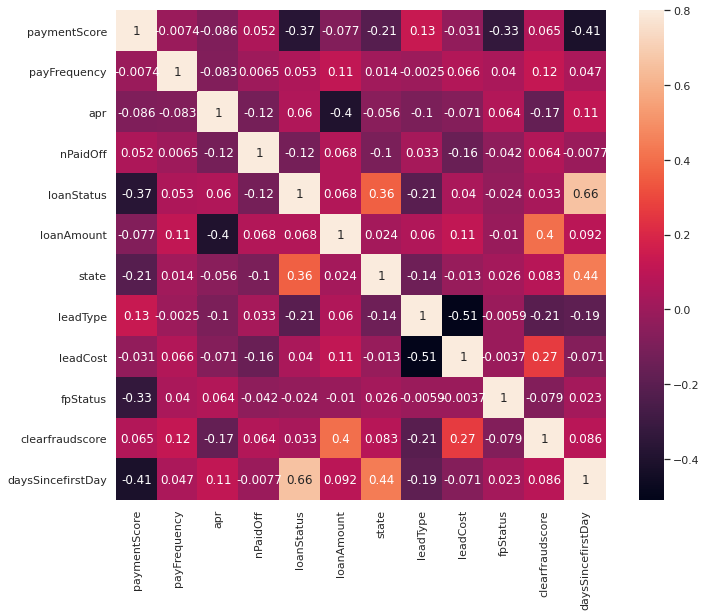

In [ ]:
#correlation matrix
corrmat = pay_loan.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=corrmat)

# **5. Model the Data**

Since the paymentScore is a continuous output, this is a Regression problem. 

I will try several Regressor models and evaluate their performance. 


In [ ]:
# libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
# split training and test data with 0.25 fraction
from sklearn.model_selection import train_test_split

X = pay_loan.drop('paymentScore', axis=1)
y = pay_loan['paymentScore']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape, y_train.shape, y_test.shape

((24057, 11), (24057,), (8020,))

In [ ]:
# defining a general function to fit and evaluate models

def model(model, X_train = X_train, X_test = X_test, y_test = y_test):
  model.fit(X_train, y_train)     # train the model
  y_pred = model.predict(X_test)  # Make predictions using the testing set
  y_train_pred = model.predict(X_train) # Make predictions using the training set

  # metrics
  mse = mean_squared_error(y_test,y_pred)
  mae = mean_absolute_error(y_test,y_pred)
  r2 = r2_score(y_test, y_pred)
  print('MSE:', mse)
  print('MAE:', mae) 
  print('R2:', r2)
  
  # plot
  plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
  plt.scatter(y_pred, y_test, c = "lightgreen", marker = "s", label = "Testing data")
  plt.xlabel("Predicted values")
  plt.ylabel("Real values")
  plt.legend(loc = "upper left")
  plt.show()
  return r2

models = {}

A litle bit about the metrics we are using to evaluate the models.



*   Mean Squared Error (MSE): Tells how close the predicted and real values are. The difference is squared. The smaller, the better. 
*   Mean Absolute Error (MAE): Tells how close the predicted and real values are. Instead of squaring the diference, the absolute difference is taken. The smaller, the better.
*   Coefficient of Determination (R2): Tells how well observed outcomes are replicated by the model, based on the proportion of total variation of outcomes explained by the model. R2 of 1 indicates a perfect fit. 



MSE: 0.06932000448679598
MAE: 0.2123157459038878
R2: 0.31582144556540415


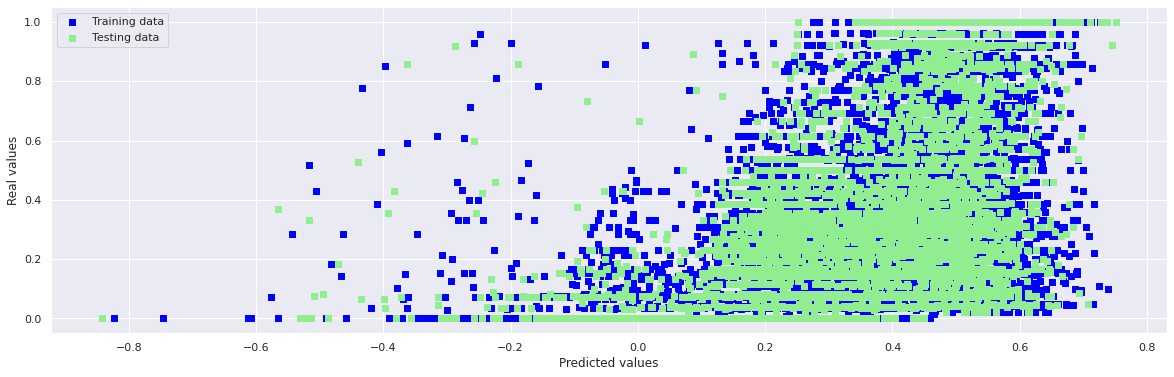

In [ ]:
# Linear Regressor
lin = LinearRegression()
r2 = model(lin)
models['lin'] = round(r2,3)
# pretty low r2 value: might suggest a more complex non-linear relationship

MSE: 0.03599224319958495
MAE: 0.1331851605488516
R2: 0.6447616946152821


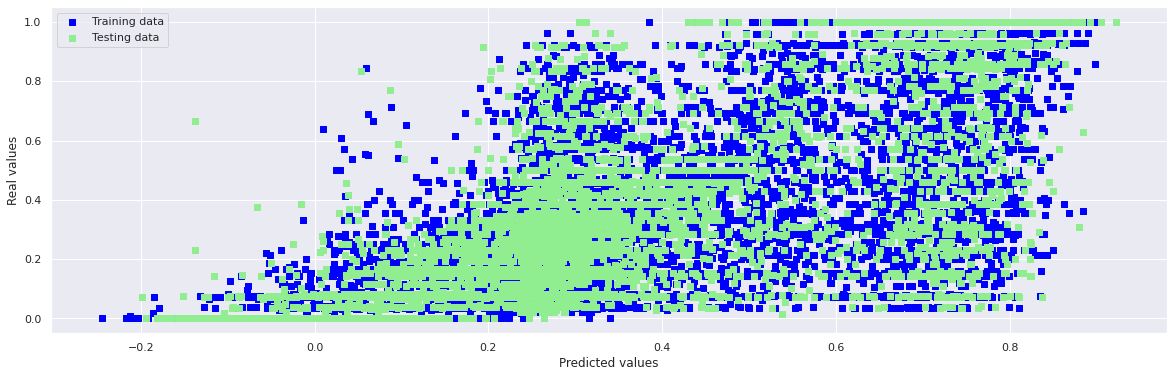

In [ ]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)
r2 = model(lightgbm)
models['lightgbm'] = round(r2,3)

MSE: 0.03488336658164453
MAE: 0.12828824949027892
R2: 0.6557061486314862


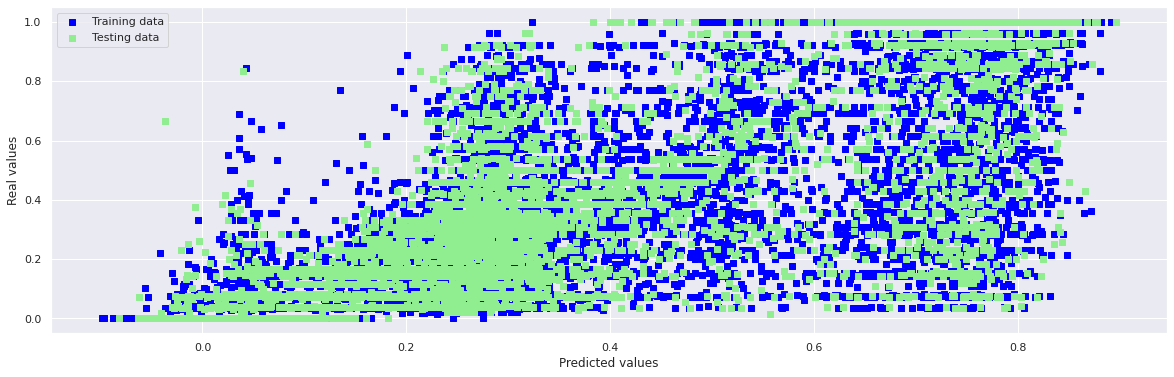

In [ ]:
# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)
r2 = model(xgboost)
models['xgboost'] = round(r2,3)

MSE: 0.03622377444691812
MAE: 0.1194077201646063
R2: 0.6424765142365501


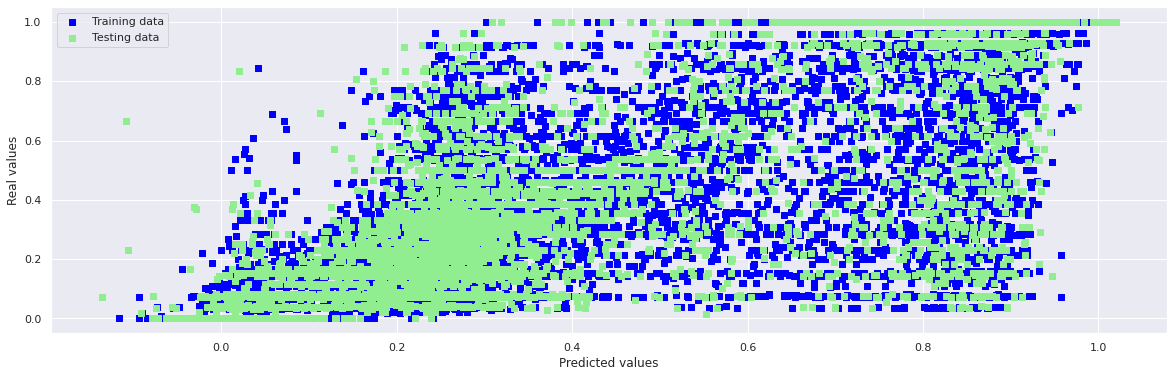

In [ ]:
# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)
r2 = model(gbr) 
models['gbr'] =round(r2,3)

MSE: 0.03479691116865229
MAE: 0.12183002409550132
R2: 0.6565594512231694


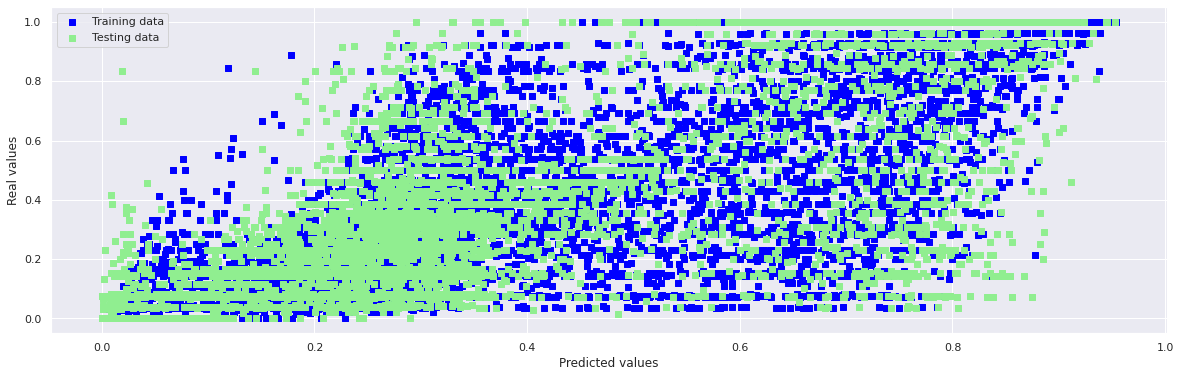

In [ ]:
# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)
r2 = model(rf)
models['rf'] = round(r2,3)

{'lin': 0.316, 'lightgbm': 0.645, 'xgboost': 0.656, 'gbr': 0.642, 'rf': 0.657}


Text(0.5, 0, 'Regression model')

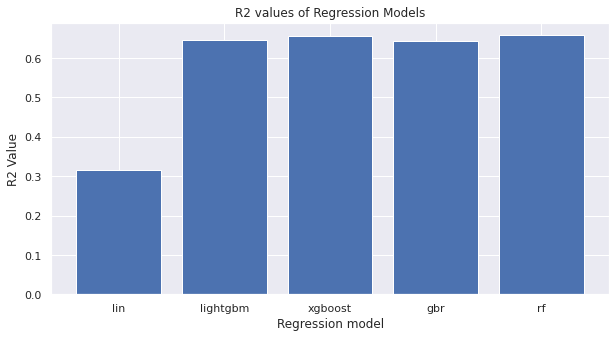

In [ ]:
# models performance
print(models)
sns.set(rc={'figure.figsize':(10,5)})
plt.bar(list(models.keys()), list(models.values()))
plt.title('R2 values of Regression Models')
plt.ylabel('R2 Value')
plt.xlabel('Regression model')

In [ ]:
# most optimal R2 
print(max(list(models.values())))

0.657


In summary, the most optimal R2 value we get for modelling the loan repayment is about 0.65. This suggests a moderate correlation between the predicted and real values.

**Experiment: Binary Classification**

Just being curious. Instead of a continuos paymentScore, we saw the distribution of paymentScore mostly grouped around 0 and 1. So, we could divide it on 0.5 and solve it as a binary classification problem. 


In [ ]:
# prepare the score data
pay_loan_b = pay_loan.copy()

def split(score):
  if score < 0.5:
    return 0
  if score >= 0.5:
    return 1

pay_loan_b['paymentScore'] = pay_loan_b['paymentScore'].apply(split)
pay_loan_b.head(3)

,paymentScore,payFrequency,apr,nPaidOff,loanStatus,loanAmount,state,leadType,leadCost,fpStatus,clearfraudscore,daysSincefirstDay
292,0,0,478.67,0.0,0,600.0,0,0,6,0,768.0,0
293,0,1,570.32,0.0,1,400.0,0,0,10,0,564.0,0
296,1,0,478.67,0.0,0,800.0,0,0,10,0,691.0,0


In [ ]:
# train test split 
X = pay_loan_b.drop('paymentScore', axis=1)
y = pay_loan_b['paymentScore']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape, y_train.shape, y_test.shape

((24057, 11), (24057,), (8020,))

In [ ]:
# libraries
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
# new metric function for binary classfication
models_b = {}

def model_b(model, X_train = X_train, X_test = X_test, y_test = y_test):
  model.fit(X_train, y_train)     # train the model
  y_pred = model.predict(X_test)  # Make predictions using the testing set

  # metrics
  acc = accuracy_score(y_test, y_pred)
  print('Accuracy is', acc)
  return acc

In [ ]:
# logistic regression
log = LogisticRegression()
acc = model_b(log)
models_b['log'] = acc

Accuracy is 0.7822942643391522


In [ ]:
# random forest classifier
rf = RandomForestClassifier()
acc = model_b(rf)
models_b['rf'] = acc

Accuracy is 0.8721945137157108


In [ ]:
# KNN Classifier
knn = KNeighborsClassifier(3)
acc = model_b(knn)
models_b['knn'] = acc

Accuracy is 0.7542394014962593


In [ ]:
# grad boosting classifier
gboost = GradientBoostingClassifier()
acc = model_b(gboost)
models_b['gboost'] = acc

Accuracy is 0.8775561097256858


In [ ]:
# decision tree classifier
dt = DecisionTreeClassifier()
acc = model_b(dt)
models_b['dt'] = acc

Accuracy is 0.8291770573566085


{'log': 0.7822942643391522, 'rf': 0.8721945137157108, 'knn': 0.7542394014962593, 'gboost': 0.8775561097256858, 'dt': 0.8291770573566085}


Text(0.5, 0, 'Classifier')

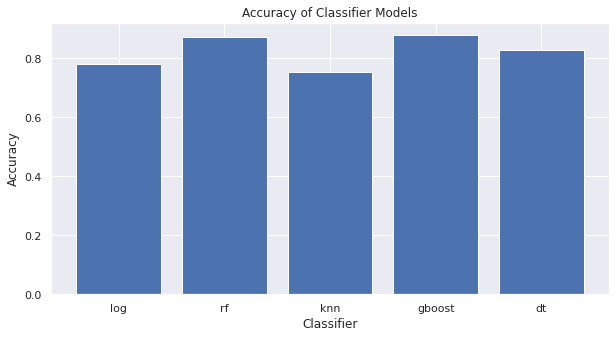

In [ ]:
# models performance
print(models_b)
sns.set(rc={'figure.figsize':(10,5)})
plt.bar(list(models_b.keys()), list(models_b.values()))
plt.title('Accuracy of Classifier Models')
plt.ylabel('Accuracy')
plt.xlabel('Classifier')

In [ ]:
# most optimal accuracy
print(max(list(models_b.values())))

0.8775561097256858


In summary, the most optimal acccuracy we obtained is about 87%. This looks great!

We should keep in mind that, by definition, a classification of '1' indicates the applicant has completed more than 50% of their payments. A class of '1' does not mean that person will have paid all of their loan. Similarly to the class '0'. 

#**6. Conclusion**

Our main business objective was to better assess the risk or quality of a loan applicant at Company X. 

I studied the datasets and understood how they could be used to solve the objective above. I transformed the payment records to give me a metric to measure the applicant's quality. I also used the clarity records to obtain their fraud score.

Using visualisations and statistics, I cleaned and analysed the data which I would be using to model. 

I treated this as a regression problem and modelled it using various Regressor models, obtaining a R2 value of 0.65.

Additionally, I tried to treat this as a classification problem and used various Classifier models, obtaining accuracy of 87%.

How to improve the models?


*   Only 7% of the loan data is used. We could explore ways to utilise the other 93%. 
*   Further investigation on why paymentScore is correlated with the dates. 
*   Further investigation on outliers.
*   We could try cross validation methods and other advanced ML techniques. 
*   We could try a classification problem where class of '1' only includes the applicants who have completed ALL payments. The rest is class '0'. Might give what we are looking for.

Thank you for checking it out!

